# Set up

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random
from joblib import Parallel, delayed
from adjustText import adjust_text
from matplotlib.patches import Ellipse

In [46]:
random.seed(42)
np.random.seed(42)

In [47]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

# PLS Analysis Function

In [4]:
def pct_var(pls: PLSRegression, X: np.ndarray, Y: np.ndarray):
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    SSX = np.sum(Xc**2)
    SSY = np.sum(Yc**2)

    T = pls.x_scores_
    P = pls.x_loadings_
    Q = pls.y_loadings_

    pct_X = []
    pct_Y = []
    for k in range(1, pls.n_components+1):
        Tk = T[:, :k]
        Pk = P[:, :k]
        Qk = Q[:, :k]

        Xhat = Tk @ Pk.T
        Yhat = Tk @ Qk.T

        pct_X.append(100 * np.sum(Xhat**2) / SSX)
        pct_Y.append(100 * np.sum(Yhat**2) / SSY)

    return np.array(pct_X), np.array(pct_Y)

In [5]:
def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

In [48]:
# inner parallelized
def pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10):
    preprocessor = ColumnTransformer(transformers=[
        # scale continuous features
        ('num', StandardScaler(), continuous_vars),
        # one-hot encode the assessment centre (drop one level to avoid collinearity)
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
    ])

    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_ncomps = []
    coefs_list = []
    # vip_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV
        pipe = make_pipeline(
            preprocessor,
            PLSRegression()
        )

        param_grid = {
            'plsregression__n_components': list(range(1, 11))
        }

        inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        grid = GridSearchCV(
            pipe, 
            param_grid, 
            cv=inner_cv, 
            scoring='neg_mean_squared_error',  # or 'r2'
            n_jobs=-1
        )
        
        grid.fit(X_train, y_train)
        best_n = grid.best_params_['plsregression__n_components']
        best_ncomps.append(best_n)
        
        y_pred = grid.predict(X_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- extract loadings and compute VIP ---
        pls = grid.best_estimator_.named_steps['plsregression']
        coefs_list.append(pls.coef_.ravel())
        
        T = pls.x_scores_
        W = pls.x_weights_
        Q = pls.y_loadings_
        p, h = W.shape

        # # S = np.sum((T ** 2) * (Q.T ** 2), axis=0)
        # S = np.sum((T ** 2) * (Q ** 2), axis=0)
        # total_S = np.sum(S)
        # vip = np.zeros(p)
        # for j in range(p):
        #     # weight_sq = [(W[j, k] ** 2) * S[k] for k in range(h)]
        #     # vip[j] = np.sqrt(p * np.sum(weight_sq) / total_S)
        #     vip[j] = np.sqrt(p * np.sum((W[j, :]**2) * S) / total_S)
        # vip_list.append(vip)

        print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
            f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'n_components (mean ± std): '
        f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
    print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
    print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')

    # # Get feature names after preprocessing
    # # First, fit the preprocessor to get the transformed feature names
    # preprocessor_fitted = preprocessor.fit(X)

    # # Get feature names for each transformer
    # num_features = continuous_vars
    # cat_features = list(preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_vars))

    # # Combine all feature names in the correct order
    # all_feature_names = num_features + cat_features


    # # Final refit on all data
    # final_pipe = make_pipeline(
    #     preprocessor,
    #     PLSRegression(
    #         n_components=int(np.round(np.mean(best_ncomps))),
    #     )
    # ).fit(X, y)

    # pls = final_pipe.named_steps['plsregression']
    # ct  = final_pipe.named_steps['columntransformer']




    # # 3) re-transform your original X to the exact matrix PLS saw
    # X_proc = ct.transform(X)            # this is a NumPy array, shape (n_samples, n_features')

    # # 4) compute the cumulative % variance explained
    # X_pctvar, Y_pctvar = pct_var(pls, X_proc, y)

    # print("Percentage of variance explained:")
    # print("Component\tX (Predictors)\tY (Response)")
    # print("-" * 40)
    # for i in range(len(X_pctvar)):
    #     print(f"PLS{i+1}\t\t{X_pctvar[i]:.2f}%\t\t{Y_pctvar[i]:.2f}%")

    # print(f"\nTotal variance explained:")
    # print(f"X: {X_pctvar[-1]:.2f}%")
    # print(f"Y: {Y_pctvar[-1]:.2f}%")

    # # Plot the results
    # plt.figure(figsize=(10, 6))
    # components = np.arange(1, len(X_pctvar) + 1)
    # plt.plot(components, X_pctvar, 'b-o', label='X (Predictors)', linewidth=2)
    # plt.plot(components, Y_pctvar, 'r-o', label='Y (Fluid Intelligence)', linewidth=2)
    # plt.xlabel('PLS Component')
    # plt.ylabel('Cumulative Variance Explained (%)')
    # plt.title('Percentage of Variance Explained by PLS Components')
    # plt.legend()
    # plt.grid(True, alpha=0.3)
    # plt.xticks(components)
    # plt.show()


    # T = pls.x_scores_

    # # Scatter plot of Fluid Intelligence Score vs PLS1 scores
    # plt.figure(figsize=(8, 6))
    # plt.scatter(T[:,0], y, alpha=0.6, s=12, color='blue')
    # plt.xlabel("PLS1 Scores")
    # plt.ylabel("Fluid Intelligence Score")
    # plt.title("Fluid Intelligence Score vs PLS1 Scores")
    # plt.show()

    # # Scatter plot of Fluid Intelligence Score vs PLS2 scores
    # plt.figure(figsize=(8, 6))
    # plt.scatter(T[:,1], y, alpha=0.6, s=12, color='red')
    # plt.xlabel("PLS2 Scores")
    # plt.ylabel("Fluid Intelligence Score")
    # plt.title("Fluid Intelligence Score vs PLS2 Scores")
    # plt.show()

    # W = pls.x_weights_
    # plt.figure(figsize=(12, 6))
    # plt.bar(all_feature_names, W[:,0])
    # plt.xticks(rotation=90)
    # plt.title("PLS1 Weights")
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.bar(all_feature_names, W[:,1])
    # plt.xticks(rotation=90)
    # plt.title("PLS2 Weights")
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.bar(all_feature_names, W[:,2])
    # plt.xticks(rotation=90)
    # plt.title("PLS3 Weights")
    # plt.tight_layout()
    # plt.show()


    # # # Calculate Z-scores for the weights
    # # W1_mean = np.mean(W[:, 0])
    # # W1_std = np.std(W[:, 0])
    # # W2_mean = np.mean(W[:, 1])
    # # W2_std = np.std(W[:, 1])

    # # plt.figure(figsize=(8, 10))
    # # plt.axhline(0, color='grey', lw=1)
    # # plt.axvline(0, color='grey', lw=1)

    # # # Draw arrows for each variable
    # # for i, var in enumerate(all_feature_names):
    # #     plt.arrow(0, 0, W[i, 0], W[i, 1], 
    # #             color='b', alpha=0.6, head_width=0.01, head_length=0.01, length_includes_head=True)

    # # # Label all variables, closer to the arrow tip
    # # texts = []
    # # for i, var in enumerate(all_feature_names):
    # #     texts.append(
    # #         plt.text(W[i, 0]*1.02, W[i, 1]*1.02, var, color='r', ha='center', va='center', 
    # #                 fontsize=8, clip_on=True)
    # #     )

    # # ellipse = Ellipse((0, 0), 
    # #                 width=6*W1_std, height=6*W2_std,  # 6 = 2*3 std devs (±3)
    # #                 fill=False, color='g', linestyle='--', linewidth=2, 
    # #                 label='Z-score = ±3 (elliptical)')
    # # plt.gca().add_patch(ellipse)

    # # adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5), 
    # #             expand_points=(1.2, 1.2), expand_text=(1.2, 1.2), force_text=0.5, force_points=0.5)

    # # plt.xlabel("PLS1 Weight")
    # # plt.ylabel("PLS2 Weight")
    # # plt.title("PLS Weight Plot")
    # # plt.grid(True)
    # # plt.axis('equal')
    # # plt.tight_layout()
    # # plt.legend()
    # # plt.show()

    # # 1. Variable names and coefficients
    # vars_to_plot = np.array(all_feature_names)
    # means = pls.x_weights_[:,0]

    # # 4. Prepare vertex data arrays
    # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
    # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

    # for var, coef in zip(vars_to_plot, means):
    #     hemi, region = varname_to_region(var)
    #     if hemi == 'lh':
    #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             lh_vertex_data[lh_labels == idx] = coef
    #     elif hemi == 'rh':
    #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             rh_vertex_data[rh_labels == idx] = coef

    # # 5. Load inflated_pre surfaces
    # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
    # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
    # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
    # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
    # lh_mesh = (lh_coords, lh_faces)
    # rh_mesh = (rh_coords, rh_faces)

    # # 6. Load fsaverage sulcal maps for background
    # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
    # sulc_left = fsavg.sulc_left
    # sulc_right = fsavg.sulc_right

    # # 7. Plotting function
    # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

    # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    #     views = ['lateral', 'medial', 'dorsal']
    #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    #     cmap = 'seismic'
    #     for i, view in enumerate(views):
    #         plotting.plot_surf_stat_map(
    #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
    #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
    #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
    #         )
    #         axes[i].set_title(view.capitalize(), fontsize=30)
    #         axes[i].axis('off')
    #     # Colorbar
    #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    #     cb.set_label('PLS1 Weights', fontsize=16)
    #     cb.ax.tick_params(labelsize=18)
    #     plt.suptitle(title, fontsize=38, y=0.96)
    #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    #     plt.show()

    # # 8. Plot with inflated_pre
    # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
    # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')

    # # 1. Variable names and coefficients
    # vars_to_plot = np.array(all_feature_names)
    # means = pls.x_weights_[:,1]

    # # 4. Prepare vertex data arrays
    # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
    # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

    # for var, coef in zip(vars_to_plot, means):
    #     hemi, region = varname_to_region(var)
    #     if hemi == 'lh':
    #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             lh_vertex_data[lh_labels == idx] = coef
    #     elif hemi == 'rh':
    #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             rh_vertex_data[rh_labels == idx] = coef

    # # 5. Load inflated_pre surfaces
    # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
    # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
    # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
    # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
    # lh_mesh = (lh_coords, lh_faces)
    # rh_mesh = (rh_coords, rh_faces)

    # # 6. Load fsaverage sulcal maps for background
    # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
    # sulc_left = fsavg.sulc_left
    # sulc_right = fsavg.sulc_right

    # # 7. Plotting function
    # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

    # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    #     views = ['lateral', 'medial', 'dorsal']
    #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    #     cmap = 'seismic'
    #     for i, view in enumerate(views):
    #         plotting.plot_surf_stat_map(
    #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
    #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
    #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
    #         )
    #         axes[i].set_title(view.capitalize(), fontsize=30)
    #         axes[i].axis('off')
    #     # Colorbar
    #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    #     cb.set_label('PLS2 Weights', fontsize=16)
    #     cb.ax.tick_params(labelsize=18)
    #     plt.suptitle(title, fontsize=38, y=0.96)
    #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    #     plt.show()

    # # 8. Plot with inflated_pre
    # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
    # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')

    # # 1. Variable names and coefficients
    # vars_to_plot = np.array(all_feature_names)
    # means = pls.x_weights_[:,2]

    # # 4. Prepare vertex data arrays
    # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
    # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

    # for var, coef in zip(vars_to_plot, means):
    #     hemi, region = varname_to_region(var)
    #     if hemi == 'lh':
    #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             lh_vertex_data[lh_labels == idx] = coef
    #     elif hemi == 'rh':
    #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
    #         for idx in idxs:
    #             rh_vertex_data[rh_labels == idx] = coef

    # # 5. Load inflated_pre surfaces
    # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
    # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
    # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
    # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
    # lh_mesh = (lh_coords, lh_faces)
    # rh_mesh = (rh_coords, rh_faces)

    # # 6. Load fsaverage sulcal maps for background
    # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
    # sulc_left = fsavg.sulc_left
    # sulc_right = fsavg.sulc_right

    # # 7. Plotting function
    # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

    # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    #     views = ['lateral', 'medial', 'dorsal']
    #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    #     cmap = 'seismic'
    #     for i, view in enumerate(views):
    #         plotting.plot_surf_stat_map(
    #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
    #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
    #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
    #         )
    #         axes[i].set_title(view.capitalize(), fontsize=30)
    #         axes[i].axis('off')
    #     # Colorbar
    #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    #     cb.set_label('PLS3 Weights', fontsize=16)
    #     cb.ax.tick_params(labelsize=18)
    #     plt.suptitle(title, fontsize=38, y=0.96)
    #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    #     plt.show()

    # # 8. Plot with inflated_pre
    # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
    # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')

In [ ]:
# # demographic only (inner parallelized)
# def pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10):
#     preprocessor = ColumnTransformer(transformers=[
#         # scale continuous features
#         ('num', StandardScaler(), continuous_vars),
#         # one-hot encode the assessment centre (drop one level to avoid collinearity)
#         ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
#     ])

#     # Cross-validation set-up
#     outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     outer_mae, outer_rmse, outer_r2 = [], [], []
#     best_ncomps = []
#     coefs_list = []
#     # vip_list = []

#     for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#         # Inner CV
#         pipe = make_pipeline(
#             preprocessor,
#             PLSRegression()
#         )

#         param_grid = {
#             'plsregression__n_components': list(range(1, 4))
#         }

#         inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
#         grid = GridSearchCV(
#             pipe, 
#             param_grid, 
#             cv=inner_cv, 
#             scoring='neg_mean_squared_error',  # or 'r2'
#             n_jobs=-1
#         )
        
#         grid.fit(X_train, y_train)
#         best_n = grid.best_params_['plsregression__n_components']
#         best_ncomps.append(best_n)
        
#         y_pred = grid.predict(X_test)

#         # --- metrics ---
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         r2 = r2_score(y_test, y_pred)

#         outer_mae.append(mae)
#         outer_rmse.append(rmse)
#         outer_r2.append(r2)

#         # --- extract loadings and compute VIP ---
#         pls = grid.best_estimator_.named_steps['plsregression']
#         coefs_list.append(pls.coef_.ravel())
        
#         T = pls.x_scores_
#         W = pls.x_weights_
#         Q = pls.y_loadings_
#         p, h = W.shape

#         # # S = np.sum((T ** 2) * (Q.T ** 2), axis=0)
#         # S = np.sum((T ** 2) * (Q ** 2), axis=0)
#         # total_S = np.sum(S)
#         # vip = np.zeros(p)
#         # for j in range(p):
#         #     # weight_sq = [(W[j, k] ** 2) * S[k] for k in range(h)]
#         #     # vip[j] = np.sqrt(p * np.sum(weight_sq) / total_S)
#         #     vip[j] = np.sqrt(p * np.sum((W[j, :]**2) * S) / total_S)
#         # vip_list.append(vip)

#         print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
#             f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

#     # Aggregate results
#     print('\n=== 10-fold CV summary ===')
#     print(f'n_components (mean ± std): '
#         f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
#     print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
#     print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
#     print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')

In [ ]:
# # outer parallelized
# def process_fold(fold_data, preprocessor, param_grid, inner_cv):
#     """Process a single fold of cross-validation"""
#     fold, train_idx, test_idx, X, y = fold_data
    
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#     # Inner CV
#     pipe = make_pipeline(
#         preprocessor,
#         PLSRegression()
#     )

#     grid = GridSearchCV(
#         pipe, 
#         param_grid, 
#         cv=inner_cv, 
#         scoring='neg_mean_squared_error',
#         n_jobs=1  # Set to 1 since we're parallelizing outer CV
#     )
    
#     grid.fit(X_train, y_train)
#     best_n = grid.best_params_['plsregression__n_components']
    
#     y_pred = grid.predict(X_test)

#     # Calculate metrics
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     r2 = r2_score(y_test, y_pred)

#     # Extract coefficients
#     pls = grid.best_estimator_.named_steps['plsregression']
#     coefs = pls.coef_.ravel()
    
#     print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
#           f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
    
#     return {
#         'fold': fold,
#         'best_n': best_n,
#         'mae': mae,
#         'rmse': rmse,
#         'r2': r2,
#         'coefs': coefs
#     }

# def pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10, n_jobs=-1):
#     preprocessor = ColumnTransformer(transformers=[
#         # scale continuous features
#         ('num', StandardScaler(), continuous_vars),
#         # one-hot encode the assessment centre (drop one level to avoid collinearity)
#         ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
#     ])

#     # Cross-validation set-up
#     outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     # Prepare fold data
#     fold_data = []
#     for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
#         fold_data.append((fold, train_idx, test_idx, X, y))
    
#     # Inner CV setup
#     param_grid = {
#         'plsregression__n_components': list(range(1, 11))
#     }
#     inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
#     # Parallel processing
#     results = Parallel(n_jobs=n_jobs, verbose=1)(
#         delayed(process_fold)(
#             fold_info, 
#             preprocessor, 
#             param_grid, 
#             inner_cv
#         ) for fold_info in fold_data
#     )
    
#     # Extract results
#     outer_mae = [r['mae'] for r in results]
#     outer_rmse = [r['rmse'] for r in results]
#     outer_r2 = [r['r2'] for r in results]
#     best_ncomps = [r['best_n'] for r in results]
#     coefs_list = [r['coefs'] for r in results]
    
#     # Aggregate results
#     print('\n=== 10-fold CV summary ===')
#     print(f'n_components (mean ± std): '
#           f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
#     print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
#     print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
#     print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')
    
#     return {
#         'mae': outer_mae,
#         'rmse': outer_rmse,
#         'r2': outer_r2,
#         'best_ncomps': best_ncomps,
#         'coefs_list': coefs_list
#     }

#     # # Get feature names after preprocessing
#     # # First, fit the preprocessor to get the transformed feature names
#     # preprocessor_fitted = preprocessor.fit(X)

#     # # Get feature names for each transformer
#     # num_features = continuous_vars
#     # cat_features = list(preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_vars))

#     # # Combine all feature names in the correct order
#     # all_feature_names = num_features + cat_features


#     # # Final refit on all data
#     # final_pipe = make_pipeline(
#     #     preprocessor,
#     #     PLSRegression(
#     #         n_components=int(np.round(np.mean(best_ncomps))),
#     #     )
#     # ).fit(X, y)

#     # pls = final_pipe.named_steps['plsregression']
#     # ct  = final_pipe.named_steps['columntransformer']




#     # # 3) re-transform your original X to the exact matrix PLS saw
#     # X_proc = ct.transform(X)            # this is a NumPy array, shape (n_samples, n_features')

#     # # 4) compute the cumulative % variance explained
#     # X_pctvar, Y_pctvar = pct_var(pls, X_proc, y)

#     # print("Percentage of variance explained:")
#     # print("Component\tX (Predictors)\tY (Response)")
#     # print("-" * 40)
#     # for i in range(len(X_pctvar)):
#     #     print(f"PLS{i+1}\t\t{X_pctvar[i]:.2f}%\t\t{Y_pctvar[i]:.2f}%")

#     # print(f"\nTotal variance explained:")
#     # print(f"X: {X_pctvar[-1]:.2f}%")
#     # print(f"Y: {Y_pctvar[-1]:.2f}%")

#     # # Plot the results
#     # plt.figure(figsize=(10, 6))
#     # components = np.arange(1, len(X_pctvar) + 1)
#     # plt.plot(components, X_pctvar, 'b-o', label='X (Predictors)', linewidth=2)
#     # plt.plot(components, Y_pctvar, 'r-o', label='Y (Fluid Intelligence)', linewidth=2)
#     # plt.xlabel('PLS Component')
#     # plt.ylabel('Cumulative Variance Explained (%)')
#     # plt.title('Percentage of Variance Explained by PLS Components')
#     # plt.legend()
#     # plt.grid(True, alpha=0.3)
#     # plt.xticks(components)
#     # plt.show()


#     # T = pls.x_scores_

#     # # Scatter plot of Fluid Intelligence Score vs PLS1 scores
#     # plt.figure(figsize=(8, 6))
#     # plt.scatter(T[:,0], y, alpha=0.6, s=12, color='blue')
#     # plt.xlabel("PLS1 Scores")
#     # plt.ylabel("Fluid Intelligence Score")
#     # plt.title("Fluid Intelligence Score vs PLS1 Scores")
#     # plt.show()

#     # # Scatter plot of Fluid Intelligence Score vs PLS2 scores
#     # plt.figure(figsize=(8, 6))
#     # plt.scatter(T[:,1], y, alpha=0.6, s=12, color='red')
#     # plt.xlabel("PLS2 Scores")
#     # plt.ylabel("Fluid Intelligence Score")
#     # plt.title("Fluid Intelligence Score vs PLS2 Scores")
#     # plt.show()

#     # W = pls.x_weights_
#     # plt.figure(figsize=(12, 6))
#     # plt.bar(all_feature_names, W[:,0])
#     # plt.xticks(rotation=90)
#     # plt.title("PLS1 Weights")
#     # plt.tight_layout()
#     # plt.show()

#     # plt.figure(figsize=(12, 6))
#     # plt.bar(all_feature_names, W[:,1])
#     # plt.xticks(rotation=90)
#     # plt.title("PLS2 Weights")
#     # plt.tight_layout()
#     # plt.show()

#     # plt.figure(figsize=(12, 6))
#     # plt.bar(all_feature_names, W[:,2])
#     # plt.xticks(rotation=90)
#     # plt.title("PLS3 Weights")
#     # plt.tight_layout()
#     # plt.show()


#     # # # Calculate Z-scores for the weights
#     # # W1_mean = np.mean(W[:, 0])
#     # # W1_std = np.std(W[:, 0])
#     # # W2_mean = np.mean(W[:, 1])
#     # # W2_std = np.std(W[:, 1])

#     # # plt.figure(figsize=(8, 10))
#     # # plt.axhline(0, color='grey', lw=1)
#     # # plt.axvline(0, color='grey', lw=1)

#     # # # Draw arrows for each variable
#     # # for i, var in enumerate(all_feature_names):
#     # #     plt.arrow(0, 0, W[i, 0], W[i, 1], 
#     # #             color='b', alpha=0.6, head_width=0.01, head_length=0.01, length_includes_head=True)

#     # # # Label all variables, closer to the arrow tip
#     # # texts = []
#     # # for i, var in enumerate(all_feature_names):
#     # #     texts.append(
#     # #         plt.text(W[i, 0]*1.02, W[i, 1]*1.02, var, color='r', ha='center', va='center', 
#     # #                 fontsize=8, clip_on=True)
#     # #     )

#     # # ellipse = Ellipse((0, 0), 
#     # #                 width=6*W1_std, height=6*W2_std,  # 6 = 2*3 std devs (±3)
#     # #                 fill=False, color='g', linestyle='--', linewidth=2, 
#     # #                 label='Z-score = ±3 (elliptical)')
#     # # plt.gca().add_patch(ellipse)

#     # # adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5), 
#     # #             expand_points=(1.2, 1.2), expand_text=(1.2, 1.2), force_text=0.5, force_points=0.5)

#     # # plt.xlabel("PLS1 Weight")
#     # # plt.ylabel("PLS2 Weight")
#     # # plt.title("PLS Weight Plot")
#     # # plt.grid(True)
#     # # plt.axis('equal')
#     # # plt.tight_layout()
#     # # plt.legend()
#     # # plt.show()

#     # # 1. Variable names and coefficients
#     # vars_to_plot = np.array(all_feature_names)
#     # means = pls.x_weights_[:,0]

#     # # 4. Prepare vertex data arrays
#     # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
#     # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

#     # for var, coef in zip(vars_to_plot, means):
#     #     hemi, region = varname_to_region(var)
#     #     if hemi == 'lh':
#     #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
#     #         for idx in idxs:
#     #             lh_vertex_data[lh_labels == idx] = coef
#     #     elif hemi == 'rh':
#     #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
#     #         for idx in idxs:
#     #             rh_vertex_data[rh_labels == idx] = coef

#     # # 5. Load inflated_pre surfaces
#     # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
#     # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
#     # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
#     # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
#     # lh_mesh = (lh_coords, lh_faces)
#     # rh_mesh = (rh_coords, rh_faces)

#     # # 6. Load fsaverage sulcal maps for background
#     # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
#     # sulc_left = fsavg.sulc_left
#     # sulc_right = fsavg.sulc_right

#     # # 7. Plotting function
#     # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

#     # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
#     #     views = ['lateral', 'medial', 'dorsal']
#     #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
#     #     cmap = 'seismic'
#     #     for i, view in enumerate(views):
#     #         plotting.plot_surf_stat_map(
#     #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
#     #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
#     #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
#     #         )
#     #         axes[i].set_title(view.capitalize(), fontsize=30)
#     #         axes[i].axis('off')
#     #     # Colorbar
#     #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
#     #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
#     #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
#     #     cb.set_label('PLS1 Weights', fontsize=16)
#     #     cb.ax.tick_params(labelsize=18)
#     #     plt.suptitle(title, fontsize=38, y=0.96)
#     #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
#     #     plt.show()

#     # # 8. Plot with inflated_pre
#     # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
#     # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')

#     # # 1. Variable names and coefficients
#     # vars_to_plot = np.array(all_feature_names)
#     # means = pls.x_weights_[:,1]

#     # # 4. Prepare vertex data arrays
#     # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
#     # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

#     # for var, coef in zip(vars_to_plot, means):
#     #     hemi, region = varname_to_region(var)
#     #     if hemi == 'lh':
#     #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
#     #         for idx in idxs:
#     #             lh_vertex_data[lh_labels == idx] = coef
#     #     elif hemi == 'rh':
#     #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
#     #         for idx in idxs:
#     #             rh_vertex_data[rh_labels == idx] = coef

#     # # 5. Load inflated_pre surfaces
#     # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
#     # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
#     # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
#     # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
#     # lh_mesh = (lh_coords, lh_faces)
#     # rh_mesh = (rh_coords, rh_faces)

#     # # 6. Load fsaverage sulcal maps for background
#     # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
#     # sulc_left = fsavg.sulc_left
#     # sulc_right = fsavg.sulc_right

#     # # 7. Plotting function
#     # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

#     # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
#     #     views = ['lateral', 'medial', 'dorsal']
#     #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
#     #     cmap = 'seismic'
#     #     for i, view in enumerate(views):
#     #         plotting.plot_surf_stat_map(
#     #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
#     #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
#     #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
#     #         )
#     #         axes[i].set_title(view.capitalize(), fontsize=30)
#     #         axes[i].axis('off')
#     #     # Colorbar
#     #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
#     #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
#     #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
#     #     cb.set_label('PLS2 Weights', fontsize=16)
#     #     cb.ax.tick_params(labelsize=18)
#     #     plt.suptitle(title, fontsize=38, y=0.96)
#     #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
#     #     plt.show()

#     # # 8. Plot with inflated_pre
#     # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
#     # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')

#     # # 1. Variable names and coefficients
#     # vars_to_plot = np.array(all_feature_names)
#     # means = pls.x_weights_[:,2]

#     # # 4. Prepare vertex data arrays
#     # lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
#     # rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

#     # for var, coef in zip(vars_to_plot, means):
#     #     hemi, region = varname_to_region(var)
#     #     if hemi == 'lh':
#     #         idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
#     #         for idx in idxs:
#     #             lh_vertex_data[lh_labels == idx] = coef
#     #     elif hemi == 'rh':
#     #         idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
#     #         for idx in idxs:
#     #             rh_vertex_data[rh_labels == idx] = coef

#     # # 5. Load inflated_pre surfaces
#     # lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
#     # rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
#     # lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
#     # rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
#     # lh_mesh = (lh_coords, lh_faces)
#     # rh_mesh = (rh_coords, rh_faces)

#     # # 6. Load fsaverage sulcal maps for background
#     # fsavg = datasets.fetch_surf_fsaverage('fsaverage')
#     # sulc_left = fsavg.sulc_left
#     # sulc_right = fsavg.sulc_right

#     # # 7. Plotting function
#     # global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

#     # def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
#     #     views = ['lateral', 'medial', 'dorsal']
#     #     fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
#     #     cmap = 'seismic'
#     #     for i, view in enumerate(views):
#     #         plotting.plot_surf_stat_map(
#     #             surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
#     #             cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
#     #             view=view, axes=axes[i], title='', figure=fig, alpha=0.9
#     #         )
#     #         axes[i].set_title(view.capitalize(), fontsize=30)
#     #         axes[i].axis('off')
#     #     # Colorbar
#     #     cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
#     #     norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
#     #     cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
#     #     cb.set_label('PLS3 Weights', fontsize=16)
#     #     cb.ax.tick_params(labelsize=18)
#     #     plt.suptitle(title, fontsize=38, y=0.96)
#     #     plt.tight_layout(rect=[0, 0.15, 1, 0.92])
#     #     plt.show()

#     # # 8. Plot with inflated_pre
#     # plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', '(Demographic + MIND)')
#     # plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', '(Demographic + MIND)')




# GF

In [16]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_GF_no_outliers.csv', index_col=0)

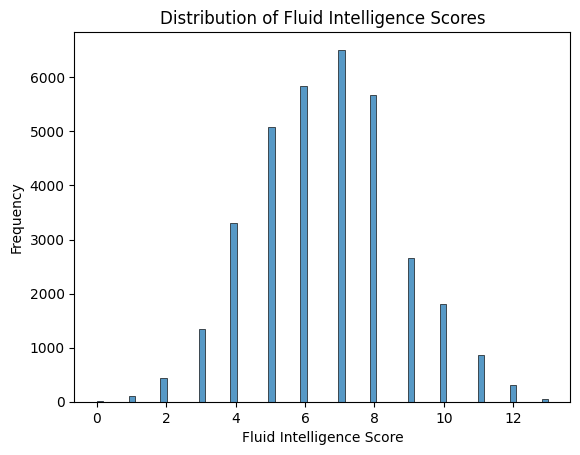

In [17]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

In [18]:
print(len(df))
print(df.shape)

33977
(33977, 2628)


## GF vs. MIND (avg)

In [10]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 71)
(33977,)


In [11]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [12]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold 01 • n_comp=04 • MAE=1.621 • RMSE=2.020 • R²=0.029
Fold 02 • n_comp=04 • MAE=1.636 • RMSE=2.034 • R²=0.031
Fold 03 • n_comp=03 • MAE=1.643 • RMSE=2.043 • R²=0.039
Fold 05 • n_comp=03 • MAE=1.605 • RMSE=2.004 • R²=0.030
Fold 06 • n_comp=03 • MAE=1.585 • RMSE=1.976 • R²=0.043
Fold 04 • n_comp=04 • MAE=1.653 • RMSE=2.059 • R²=0.032
Fold 07 • n_comp=03 • MAE=1.617 • RMSE=2.018 • R²=0.032
Fold 08 • n_comp=03 • MAE=1.657 • RMSE=2.052 • R²=0.022


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   20.9s remaining:   13.9s


Fold 09 • n_comp=03 • MAE=1.607 • RMSE=2.002 • R²=0.036
Fold 10 • n_comp=04 • MAE=1.629 • RMSE=2.034 • R²=0.035

=== 10-fold CV summary ===
n_components (mean ± std): 3.4 ± 0.5
MAE :  1.625 ± 0.022
RMSE:  2.024 ± 0.024
R²  :  0.033 ± 0.005


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.2s finished


{'mae': [1.620789683747022,
  1.6356164805814626,
  1.642542629589212,
  1.6534124119544573,
  1.6054795429416169,
  1.5846702375308779,
  1.6172456688401584,
  1.6571770620871595,
  1.6067854339932959,
  1.6289274423638291],
 'rmse': [2.020214498757342,
  2.034122232698095,
  2.043146129813315,
  2.0587159145474265,
  2.0035988623392496,
  1.976143001357726,
  2.017552574375593,
  2.052391067967517,
  2.001701708294878,
  2.0337991843519947],
 'r2': [0.029303726442954425,
  0.031136177578584223,
  0.038595506345630026,
  0.032193101185941986,
  0.030274696877667817,
  0.04290803813160904,
  0.03165555258542474,
  0.021858018339525276,
  0.035701661345695856,
  0.03503041388575934],
 'best_ncomps': [4, 4, 3, 4, 3, 3, 3, 3, 3, 4],
 'coefs_list': [array([-0.10647198,  0.05104017,  0.00298554, -0.00762325,  0.01547378,
         -0.00061085,  0.03326275,  0.00101938,  0.05353717, -0.04315915,
          0.00299405,  0.05862305, -0.01526592, -0.01023638, -0.00919078,
          0.00037305,  0

## GF vs. MIND

In [12]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 2281)
(33977,)


In [ ]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

Columns renamed successfully.


In [14]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=1.605 • RMSE=2.005 • R²=0.044
Fold 02 • n_comp=06 • MAE=1.624 • RMSE=2.024 • R²=0.041
Fold 03 • n_comp=06 • MAE=1.633 • RMSE=2.038 • R²=0.044
Fold 04 • n_comp=06 • MAE=1.651 • RMSE=2.058 • R²=0.033
Fold 05 • n_comp=06 • MAE=1.601 • RMSE=1.997 • R²=0.037
Fold 06 • n_comp=06 • MAE=1.565 • RMSE=1.957 • R²=0.061
Fold 07 • n_comp=06 • MAE=1.606 • RMSE=2.008 • R²=0.041
Fold 08 • n_comp=06 • MAE=1.646 • RMSE=2.037 • R²=0.037
Fold 09 • n_comp=06 • MAE=1.603 • RMSE=1.997 • R²=0.040
Fold 10 • n_comp=06 • MAE=1.625 • RMSE=2.035 • R²=0.034

=== 10-fold CV summary ===
n_components (mean ± std): 6.0 ± 0.0
MAE :  1.616 ± 0.024
RMSE:  2.016 ± 0.027
R²  :  0.041 ± 0.008


## GF vs. CT

In [13]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 65)
(33977,)


In [14]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [15]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=1.632 • RMSE=2.032 • R²=0.018
Fold 02 • n_comp=05 • MAE=1.644 • RMSE=2.042 • R²=0.024
Fold 03 • n_comp=09 • MAE=1.651 • RMSE=2.057 • R²=0.026
Fold 04 • n_comp=05 • MAE=1.662 • RMSE=2.070 • R²=0.021
Fold 05 • n_comp=05 • MAE=1.604 • RMSE=2.002 • R²=0.032
Fold 06 • n_comp=05 • MAE=1.589 • RMSE=1.985 • R²=0.035
Fold 07 • n_comp=06 • MAE=1.631 • RMSE=2.035 • R²=0.015
Fold 08 • n_comp=08 • MAE=1.652 • RMSE=2.046 • R²=0.028
Fold 09 • n_comp=09 • MAE=1.623 • RMSE=2.016 • R²=0.022
Fold 10 • n_comp=06 • MAE=1.637 • RMSE=2.043 • R²=0.026

=== 10-fold CV summary ===
n_components (mean ± std): 6.4 ± 1.6
MAE :  1.632 ± 0.021
RMSE:  2.033 ± 0.024
R²  :  0.025 ± 0.006


## GF vs. FC

In [16]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 214)
(33977,)


In [17]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [18]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 01 • n_comp=05 • MAE=1.581 • RMSE=1.985 • R²=0.063
Fold 02 • n_comp=05 • MAE=1.599 • RMSE=1.990 • R²=0.073
Fold 03 • n_comp=05 • MAE=1.615 • RMSE=2.020 • R²=0.060
Fold 04 • n_comp=05 • MAE=1.615 • RMSE=2.018 • R²=0.070
Fold 05 • n_comp=05 • MAE=1.573 • RMSE=1.964 • R²=0.068
Fold 06 • n_comp=05 • MAE=1.545 • RMSE=1.929 • R²=0.088
Fold 07 • n_comp=05 • MAE=1.598 • RMSE=1.995 • R²=0.053
Fold 08 • n_comp=05 • MAE=1.604 • RMSE=2.000 • R²=0.071
Fold 09 • n_comp=05 • MAE=1.572 • RMSE=1.965 • R²=0.070
Fold 10 • n_comp=05 • MAE=1.590 • RMSE=1.987 • R²=0.079

=== 10-fold CV summary ===
n_components (mean ± std): 5.0 ± 0.0
MAE :  1.589 ± 0.021
RMSE:  1.985 ± 0.026
R²  :  0.070 ± 0.009


## GF vs. Demographic Data

In [19]:
# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 3)
(33977,)


In [20]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [21]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=02 • MAE=1.634 • RMSE=2.040 • R²=0.010
Fold 02 • n_comp=02 • MAE=1.654 • RMSE=2.051 • R²=0.015
Fold 03 • n_comp=02 • MAE=1.666 • RMSE=2.072 • R²=0.012
Fold 04 • n_comp=02 • MAE=1.670 • RMSE=2.076 • R²=0.015
Fold 05 • n_comp=02 • MAE=1.614 • RMSE=2.015 • R²=0.019
Fold 06 • n_comp=02 • MAE=1.601 • RMSE=1.998 • R²=0.022
Fold 07 • n_comp=03 • MAE=1.642 • RMSE=2.044 • R²=0.006
Fold 08 • n_comp=02 • MAE=1.670 • RMSE=2.062 • R²=0.012
Fold 09 • n_comp=02 • MAE=1.631 • RMSE=2.023 • R²=0.015
Fold 10 • n_comp=02 • MAE=1.652 • RMSE=2.054 • R²=0.016

=== 10-fold CV summary ===
n_components (mean ± std): 2.1 ± 0.3
MAE :  1.643 ± 0.022
RMSE:  2.044 ± 0.024
R²  :  0.014 ± 0.004


# PAL

In [22]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_PAL_no_outliers.csv', index_col=0)

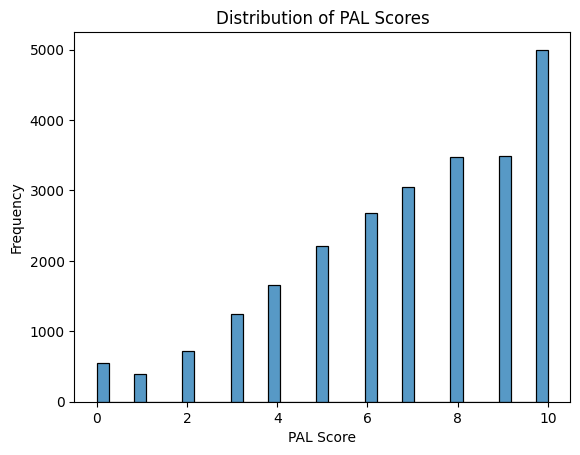

In [23]:
# Histogram of PAL Scores
sns.histplot(df['20197-2.0'])
plt.title('Distribution of PAL Scores')
plt.xlabel('PAL Score')
plt.ylabel('Frequency')
plt.show()

In [24]:
print(len(df))
print(df.shape)

24492
(24492, 2628)


### PAL vs. MIND (avg)

In [10]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 71)
(24492,)


In [11]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [12]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=05 • MAE=2.076 • RMSE=2.539 • R²=0.064
Fold 02 • n_comp=05 • MAE=2.104 • RMSE=2.551 • R²=0.046
Fold 03 • n_comp=05 • MAE=2.098 • RMSE=2.584 • R²=0.062
Fold 04 • n_comp=04 • MAE=2.071 • RMSE=2.533 • R²=0.059
Fold 05 • n_comp=05 • MAE=2.040 • RMSE=2.476 • R²=0.053
Fold 06 • n_comp=04 • MAE=2.105 • RMSE=2.559 • R²=0.081
Fold 07 • n_comp=05 • MAE=2.089 • RMSE=2.538 • R²=0.062
Fold 08 • n_comp=05 • MAE=2.068 • RMSE=2.536 • R²=0.065
Fold 09 • n_comp=05 • MAE=2.082 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.070 • RMSE=2.542 • R²=0.047

=== 10-fold CV summary ===
n_components (mean ± std): 4.8 ± 0.4
MAE :  2.080 ± 0.019
RMSE:  2.541 ± 0.026
R²  :  0.061 ± 0.009


### PAL vs. MIND

In [13]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 2281)
(24492,)


In [14]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [15]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=07 • MAE=2.088 • RMSE=2.558 • R²=0.050
Fold 02 • n_comp=07 • MAE=2.105 • RMSE=2.551 • R²=0.046
Fold 03 • n_comp=07 • MAE=2.105 • RMSE=2.589 • R²=0.058
Fold 04 • n_comp=09 • MAE=2.091 • RMSE=2.564 • R²=0.036
Fold 05 • n_comp=07 • MAE=2.061 • RMSE=2.501 • R²=0.035
Fold 06 • n_comp=06 • MAE=2.129 • RMSE=2.598 • R²=0.052
Fold 07 • n_comp=08 • MAE=2.113 • RMSE=2.576 • R²=0.034
Fold 08 • n_comp=06 • MAE=2.085 • RMSE=2.557 • R²=0.049
Fold 09 • n_comp=09 • MAE=2.092 • RMSE=2.571 • R²=0.054
Fold 10 • n_comp=06 • MAE=2.088 • RMSE=2.559 • R²=0.035

=== 10-fold CV summary ===
n_components (mean ± std): 7.2 ± 1.1
MAE :  2.096 ± 0.018
RMSE:  2.562 ± 0.025
R²  :  0.045 ± 0.009


### PAL vs. CT

In [16]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 65)
(24492,)


In [17]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [18]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=05 • MAE=2.081 • RMSE=2.537 • R²=0.066
Fold 02 • n_comp=05 • MAE=2.106 • RMSE=2.556 • R²=0.043
Fold 03 • n_comp=05 • MAE=2.096 • RMSE=2.581 • R²=0.064
Fold 04 • n_comp=05 • MAE=2.065 • RMSE=2.532 • R²=0.060
Fold 05 • n_comp=05 • MAE=2.041 • RMSE=2.475 • R²=0.055
Fold 06 • n_comp=06 • MAE=2.107 • RMSE=2.564 • R²=0.077
Fold 07 • n_comp=05 • MAE=2.087 • RMSE=2.537 • R²=0.063
Fold 08 • n_comp=05 • MAE=2.073 • RMSE=2.540 • R²=0.061
Fold 09 • n_comp=05 • MAE=2.084 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.076 • RMSE=2.542 • R²=0.048

=== 10-fold CV summary ===
n_components (mean ± std): 5.1 ± 0.3
MAE :  2.082 ± 0.019
RMSE:  2.542 ± 0.027
R²  :  0.060 ± 0.009


### PAL vs. FC

In [19]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 214)
(24492,)


In [20]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [21]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=09 • MAE=2.035 • RMSE=2.503 • R²=0.091
Fold 02 • n_comp=10 • MAE=2.039 • RMSE=2.497 • R²=0.087
Fold 03 • n_comp=09 • MAE=2.055 • RMSE=2.543 • R²=0.091
Fold 04 • n_comp=09 • MAE=2.035 • RMSE=2.496 • R²=0.087
Fold 05 • n_comp=10 • MAE=1.994 • RMSE=2.423 • R²=0.093
Fold 06 • n_comp=09 • MAE=2.053 • RMSE=2.523 • R²=0.106
Fold 07 • n_comp=10 • MAE=2.031 • RMSE=2.487 • R²=0.099
Fold 08 • n_comp=09 • MAE=2.032 • RMSE=2.500 • R²=0.091
Fold 09 • n_comp=09 • MAE=2.037 • RMSE=2.515 • R²=0.094
Fold 10 • n_comp=10 • MAE=2.016 • RMSE=2.484 • R²=0.091

=== 10-fold CV summary ===
n_components (mean ± std): 9.4 ± 0.5
MAE :  2.033 ± 0.017
RMSE:  2.497 ± 0.030
R²  :  0.093 ± 0.006


## PAL vs. Demographic Data

In [25]:
# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 3)
(24492,)


In [26]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [27]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=03 • MAE=2.088 • RMSE=2.546 • R²=0.059
Fold 02 • n_comp=03 • MAE=2.105 • RMSE=2.556 • R²=0.043
Fold 03 • n_comp=03 • MAE=2.101 • RMSE=2.587 • R²=0.059
Fold 04 • n_comp=03 • MAE=2.074 • RMSE=2.537 • R²=0.056
Fold 05 • n_comp=03 • MAE=2.044 • RMSE=2.473 • R²=0.056
Fold 06 • n_comp=03 • MAE=2.114 • RMSE=2.571 • R²=0.071
Fold 07 • n_comp=03 • MAE=2.092 • RMSE=2.544 • R²=0.058
Fold 08 • n_comp=03 • MAE=2.069 • RMSE=2.536 • R²=0.065
Fold 09 • n_comp=03 • MAE=2.086 • RMSE=2.557 • R²=0.064
Fold 10 • n_comp=03 • MAE=2.075 • RMSE=2.543 • R²=0.047

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  2.085 ± 0.019
RMSE:  2.545 ± 0.029
R²  :  0.058 ± 0.008


# DSST

In [28]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_DSST_no_outliers.csv', index_col=0)

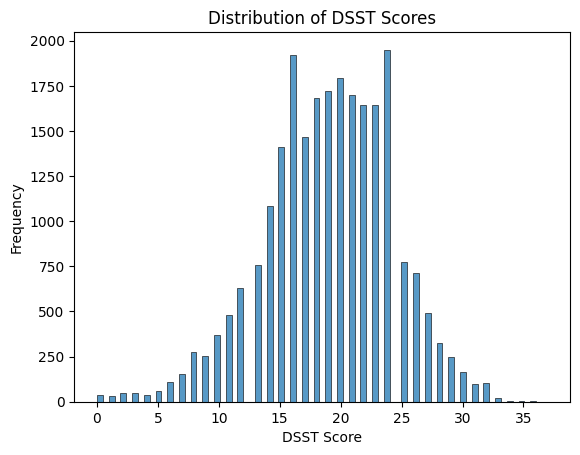

In [29]:
# Histogram of DSST Scores
sns.histplot(df['23324-2.0'])
plt.title('Distribution of DSST Scores')
plt.xlabel('DSST Score')
plt.ylabel('Frequency')
plt.show()

In [30]:
print(len(df))
print(df.shape)

24275
(24275, 2628)


### DSST vs. MIND (avg)

In [25]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 71)
(24275,)


In [26]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [27]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=05 • MAE=3.703 • RMSE=4.712 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.804 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=05 • MAE=3.725 • RMSE=4.712 • R²=0.200
Fold 04 • n_comp=06 • MAE=3.665 • RMSE=4.619 • R²=0.161
Fold 05 • n_comp=06 • MAE=3.782 • RMSE=4.816 • R²=0.181
Fold 06 • n_comp=06 • MAE=3.701 • RMSE=4.738 • R²=0.195
Fold 07 • n_comp=06 • MAE=3.738 • RMSE=4.754 • R²=0.188
Fold 08 • n_comp=06 • MAE=3.713 • RMSE=4.738 • R²=0.184
Fold 09 • n_comp=06 • MAE=3.640 • RMSE=4.636 • R²=0.189
Fold 10 • n_comp=06 • MAE=3.650 • RMSE=4.597 • R²=0.203

=== 10-fold CV summary ===
n_components (mean ± std): 5.8 ± 0.4
MAE :  3.712 ± 0.050
RMSE:  4.717 ± 0.077
R²  :  0.190 ± 0.013


### DSST vs. MIND

In [28]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 2281)
(24275,)


In [29]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [30]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=10 • MAE=3.764 • RMSE=4.769 • R²=0.173
Fold 02 • n_comp=10 • MAE=3.865 • RMSE=4.909 • R²=0.186
Fold 03 • n_comp=10 • MAE=3.760 • RMSE=4.766 • R²=0.181
Fold 04 • n_comp=10 • MAE=3.686 • RMSE=4.673 • R²=0.141
Fold 05 • n_comp=10 • MAE=3.821 • RMSE=4.863 • R²=0.165
Fold 06 • n_comp=10 • MAE=3.772 • RMSE=4.812 • R²=0.170
Fold 07 • n_comp=10 • MAE=3.816 • RMSE=4.831 • R²=0.162
Fold 08 • n_comp=10 • MAE=3.761 • RMSE=4.808 • R²=0.159
Fold 09 • n_comp=10 • MAE=3.675 • RMSE=4.670 • R²=0.178
Fold 10 • n_comp=10 • MAE=3.686 • RMSE=4.649 • R²=0.185

=== 10-fold CV summary ===
n_components (mean ± std): 10.0 ± 0.0
MAE :  3.761 ± 0.060
RMSE:  4.775 ± 0.083
R²  :  0.170 ± 0.013


### DSST vs. CT

In [31]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 65)
(24275,)


In [32]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [33]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=3.709 • RMSE=4.711 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.811 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=06 • MAE=3.715 • RMSE=4.713 • R²=0.199
Fold 04 • n_comp=06 • MAE=3.659 • RMSE=4.612 • R²=0.163
Fold 05 • n_comp=06 • MAE=3.789 • RMSE=4.831 • R²=0.176
Fold 06 • n_comp=06 • MAE=3.700 • RMSE=4.728 • R²=0.198
Fold 07 • n_comp=06 • MAE=3.743 • RMSE=4.774 • R²=0.181
Fold 08 • n_comp=06 • MAE=3.722 • RMSE=4.751 • R²=0.179
Fold 09 • n_comp=06 • MAE=3.643 • RMSE=4.639 • R²=0.188
Fold 10 • n_comp=06 • MAE=3.652 • RMSE=4.610 • R²=0.198

=== 10-fold CV summary ===
n_components (mean ± std): 6.0 ± 0.0
MAE :  3.714 ± 0.053
RMSE:  4.721 ± 0.079
R²  :  0.188 ± 0.013


### DSST vs. FC

In [34]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 214)
(24275,)


In [35]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [36]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=09 • MAE=3.647 • RMSE=4.658 • R²=0.211
Fold 02 • n_comp=09 • MAE=3.773 • RMSE=4.814 • R²=0.217
Fold 03 • n_comp=09 • MAE=3.699 • RMSE=4.674 • R²=0.213
Fold 04 • n_comp=09 • MAE=3.648 • RMSE=4.611 • R²=0.164
Fold 05 • n_comp=09 • MAE=3.779 • RMSE=4.796 • R²=0.188
Fold 06 • n_comp=09 • MAE=3.669 • RMSE=4.691 • R²=0.211
Fold 07 • n_comp=09 • MAE=3.714 • RMSE=4.719 • R²=0.200
Fold 08 • n_comp=10 • MAE=3.684 • RMSE=4.727 • R²=0.187
Fold 09 • n_comp=10 • MAE=3.633 • RMSE=4.616 • R²=0.196
Fold 10 • n_comp=09 • MAE=3.617 • RMSE=4.565 • R²=0.214

=== 10-fold CV summary ===
n_components (mean ± std): 9.2 ± 0.4
MAE :  3.686 ± 0.053
RMSE:  4.687 ± 0.076
R²  :  0.200 ± 0.016


## DSST vs. Demographic Data

In [31]:
# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 3)
(24275,)


In [32]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [33]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=03 • MAE=3.725 • RMSE=4.734 • R²=0.185
Fold 02 • n_comp=03 • MAE=3.810 • RMSE=4.852 • R²=0.205
Fold 03 • n_comp=03 • MAE=3.722 • RMSE=4.722 • R²=0.196
Fold 04 • n_comp=03 • MAE=3.674 • RMSE=4.631 • R²=0.156
Fold 05 • n_comp=03 • MAE=3.798 • RMSE=4.849 • R²=0.170
Fold 06 • n_comp=03 • MAE=3.716 • RMSE=4.749 • R²=0.191
Fold 07 • n_comp=03 • MAE=3.761 • RMSE=4.786 • R²=0.177
Fold 08 • n_comp=03 • MAE=3.731 • RMSE=4.774 • R²=0.171
Fold 09 • n_comp=03 • MAE=3.657 • RMSE=4.660 • R²=0.181
Fold 10 • n_comp=03 • MAE=3.666 • RMSE=4.622 • R²=0.194

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  3.726 ± 0.050
RMSE:  4.738 ± 0.078
R²  :  0.183 ± 0.014


# TMT

In [49]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_TMT_no_outliers.csv', index_col=0)

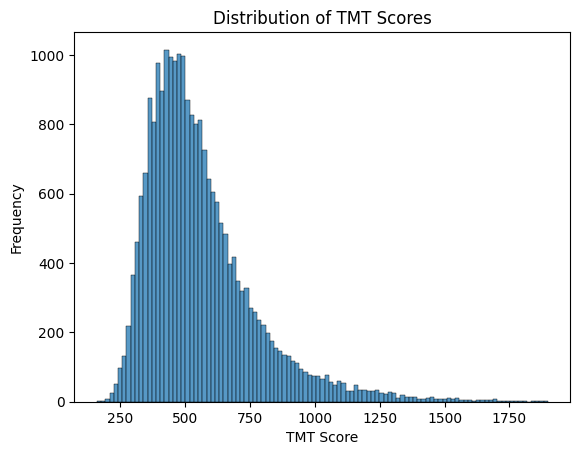

In [50]:
# Histogram of TMT Scores
sns.histplot(df['trailmaking_score'])
plt.title('Distribution of TMT Scores')
plt.xlabel('TMT Score')
plt.ylabel('Frequency')
plt.show()

In [51]:
print(len(df))
print(df.shape)

23362
(23362, 2628)


### TMT vs. MIND (avg)

In [52]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 71)
(23362,)


In [53]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [54]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=152.318 • RMSE=204.732 • R²=0.098
Fold 02 • n_comp=06 • MAE=142.837 • RMSE=190.780 • R²=0.137
Fold 03 • n_comp=06 • MAE=144.857 • RMSE=197.484 • R²=0.121
Fold 04 • n_comp=06 • MAE=142.657 • RMSE=197.176 • R²=0.136
Fold 05 • n_comp=06 • MAE=140.738 • RMSE=190.721 • R²=0.133
Fold 06 • n_comp=06 • MAE=144.204 • RMSE=201.155 • R²=0.125
Fold 07 • n_comp=06 • MAE=144.319 • RMSE=195.567 • R²=0.133
Fold 08 • n_comp=07 • MAE=146.228 • RMSE=203.530 • R²=0.146
Fold 09 • n_comp=05 • MAE=147.680 • RMSE=203.748 • R²=0.124
Fold 10 • n_comp=05 • MAE=147.192 • RMSE=202.258 • R²=0.153

=== 10-fold CV summary ===
n_components (mean ± std): 5.9 ± 0.5
MAE :  145.303 ± 3.092
RMSE:  198.715 ± 4.938
R²  :  0.131 ± 0.014


### TMT vs. MIND

In [55]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 2281)
(23362,)


In [56]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [57]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=10 • MAE=154.170 • RMSE=207.349 • R²=0.075
Fold 02 • n_comp=10 • MAE=144.555 • RMSE=192.138 • R²=0.125
Fold 03 • n_comp=10 • MAE=146.401 • RMSE=198.617 • R²=0.111
Fold 04 • n_comp=10 • MAE=143.089 • RMSE=197.674 • R²=0.131
Fold 05 • n_comp=10 • MAE=143.380 • RMSE=193.257 • R²=0.110
Fold 06 • n_comp=10 • MAE=145.262 • RMSE=202.085 • R²=0.117
Fold 07 • n_comp=10 • MAE=146.335 • RMSE=197.612 • R²=0.115
Fold 08 • n_comp=10 • MAE=148.679 • RMSE=205.495 • R²=0.130
Fold 09 • n_comp=10 • MAE=150.024 • RMSE=206.563 • R²=0.100
Fold 10 • n_comp=10 • MAE=147.616 • RMSE=202.686 • R²=0.149

=== 10-fold CV summary ===
n_components (mean ± std): 10.0 ± 0.0
MAE :  146.951 ± 3.193
RMSE:  200.348 ± 5.079
R²  :  0.116 ± 0.019


### TMT vs. CT

In [58]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 65)
(23362,)


In [59]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [60]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=06 • MAE=152.069 • RMSE=204.187 • R²=0.103
Fold 02 • n_comp=05 • MAE=142.597 • RMSE=190.942 • R²=0.136
Fold 03 • n_comp=05 • MAE=145.190 • RMSE=197.621 • R²=0.119
Fold 04 • n_comp=05 • MAE=141.833 • RMSE=197.567 • R²=0.132
Fold 05 • n_comp=05 • MAE=141.372 • RMSE=191.402 • R²=0.127
Fold 06 • n_comp=05 • MAE=145.111 • RMSE=201.368 • R²=0.123
Fold 07 • n_comp=05 • MAE=145.290 • RMSE=195.711 • R²=0.132
Fold 08 • n_comp=05 • MAE=147.614 • RMSE=204.960 • R²=0.134
Fold 09 • n_comp=05 • MAE=147.860 • RMSE=203.735 • R²=0.125
Fold 10 • n_comp=05 • MAE=148.069 • RMSE=202.969 • R²=0.147

=== 10-fold CV summary ===
n_components (mean ± std): 5.1 ± 0.3
MAE :  145.700 ± 3.140
RMSE:  199.046 ± 4.936
R²  :  0.128 ± 0.011


### TMT vs. FC

In [61]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 214)
(23362,)


In [62]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [63]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=10 • MAE=150.771 • RMSE=201.648 • R²=0.125
Fold 02 • n_comp=09 • MAE=142.185 • RMSE=189.841 • R²=0.146
Fold 03 • n_comp=09 • MAE=143.033 • RMSE=195.107 • R²=0.142
Fold 04 • n_comp=10 • MAE=139.365 • RMSE=193.056 • R²=0.171
Fold 05 • n_comp=09 • MAE=140.170 • RMSE=189.078 • R²=0.148
Fold 06 • n_comp=09 • MAE=143.335 • RMSE=198.413 • R²=0.149
Fold 07 • n_comp=09 • MAE=141.680 • RMSE=192.026 • R²=0.165
Fold 08 • n_comp=09 • MAE=144.788 • RMSE=200.041 • R²=0.175
Fold 09 • n_comp=08 • MAE=143.833 • RMSE=199.569 • R²=0.160
Fold 10 • n_comp=08 • MAE=146.041 • RMSE=200.870 • R²=0.164

=== 10-fold CV summary ===
n_components (mean ± std): 9.0 ± 0.6
MAE :  143.520 ± 3.075
RMSE:  195.965 ± 4.490
R²  :  0.154 ± 0.015


## TMT vs. Demographic Data

In [37]:
# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 3)
(23362,)


In [38]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [39]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=03 • MAE=152.282 • RMSE=204.259 • R²=0.102
Fold 02 • n_comp=03 • MAE=142.748 • RMSE=191.249 • R²=0.133
Fold 03 • n_comp=03 • MAE=145.659 • RMSE=198.146 • R²=0.115
Fold 04 • n_comp=03 • MAE=142.949 • RMSE=198.163 • R²=0.127
Fold 05 • n_comp=03 • MAE=141.653 • RMSE=191.782 • R²=0.123
Fold 06 • n_comp=03 • MAE=145.550 • RMSE=202.484 • R²=0.114
Fold 07 • n_comp=03 • MAE=145.553 • RMSE=196.516 • R²=0.125
Fold 08 • n_comp=03 • MAE=147.787 • RMSE=205.066 • R²=0.133
Fold 09 • n_comp=03 • MAE=147.829 • RMSE=203.702 • R²=0.125
Fold 10 • n_comp=03 • MAE=149.105 • RMSE=204.382 • R²=0.135

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  146.111 ± 3.079
RMSE:  199.575 ± 4.941
R²  :  0.123 ± 0.010


# All Cognitive Data

In [64]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_allcols_no_outliers.csv', index_col=0)

In [65]:
print(len(df))
print(df.shape)

23188
(23188, 2628)


### All Data vs. MIND (avg)

In [66]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(23188, 72)
(23188, 4)


In [67]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [68]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 01 • n_comp=06 • MAE=38.963 • RMSE=103.069 • R²=0.105
Fold 02 • n_comp=07 • MAE=38.815 • RMSE=99.729 • R²=0.107
Fold 03 • n_comp=06 • MAE=37.902 • RMSE=98.066 • R²=0.092
Fold 04 • n_comp=06 • MAE=37.266 • RMSE=96.908 • R²=0.105
Fold 05 • n_comp=06 • MAE=37.185 • RMSE=96.130 • R²=0.114
Fold 06 • n_comp=06 • MAE=37.326 • RMSE=97.993 • R²=0.098
Fold 07 • n_comp=06 • MAE=38.435 • RMSE=101.136 • R²=0.105
Fold 08 • n_comp=06 • MAE=37.059 • RMSE=95.961 • R²=0.096
Fold 09 • n_comp=06 • MAE=38.013 • RMSE=97.666 • R²=0.098
Fold 10 • n_comp=06 • MAE=37.006 • RMSE=96.941 • R²=0.106

=== 10-fold CV summary ===
n_components (mean ± std): 6.1 ± 0.3
MAE :  37.797 ± 0.701
RMSE:  98.360 ± 2.175
R²  :  0.103 ± 0.006


### All Data vs. MIND

In [69]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(23188, 2282)
(23188, 4)


In [70]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [71]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=10 • MAE=39.348 • RMSE=104.118 • R²=0.092
Fold 02 • n_comp=10 • MAE=39.267 • RMSE=100.462 • R²=0.087
Fold 03 • n_comp=10 • MAE=38.077 • RMSE=98.722 • R²=0.079
Fold 04 • n_comp=10 • MAE=37.735 • RMSE=98.075 • R²=0.084
Fold 05 • n_comp=10 • MAE=37.670 • RMSE=97.302 • R²=0.102
Fold 06 • n_comp=10 • MAE=37.887 • RMSE=99.169 • R²=0.080
Fold 07 • n_comp=10 • MAE=38.876 • RMSE=102.051 • R²=0.087
Fold 08 • n_comp=10 • MAE=37.346 • RMSE=96.161 • R²=0.085
Fold 09 • n_comp=10 • MAE=38.023 • RMSE=98.109 • R²=0.089
Fold 10 • n_comp=10 • MAE=37.712 • RMSE=98.031 • R²=0.090

=== 10-fold CV summary ===
n_components (mean ± std): 10.0 ± 0.0
MAE :  38.194 ± 0.672
RMSE:  99.220 ± 2.254
R²  :  0.088 ± 0.006


### All Data vs. CT

In [72]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(23188, 66)
(23188, 4)


In [73]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [74]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=09 • MAE=39.060 • RMSE=103.071 • R²=0.101
Fold 02 • n_comp=10 • MAE=39.027 • RMSE=100.050 • R²=0.100
Fold 03 • n_comp=08 • MAE=37.872 • RMSE=98.257 • R²=0.091
Fold 04 • n_comp=08 • MAE=37.548 • RMSE=97.138 • R²=0.101
Fold 05 • n_comp=08 • MAE=37.295 • RMSE=96.739 • R²=0.108
Fold 06 • n_comp=08 • MAE=37.452 • RMSE=98.318 • R²=0.095
Fold 07 • n_comp=08 • MAE=38.687 • RMSE=101.365 • R²=0.102
Fold 08 • n_comp=08 • MAE=37.230 • RMSE=95.997 • R²=0.093
Fold 09 • n_comp=08 • MAE=37.999 • RMSE=97.598 • R²=0.096
Fold 10 • n_comp=08 • MAE=37.003 • RMSE=97.023 • R²=0.105

=== 10-fold CV summary ===
n_components (mean ± std): 8.3 ± 0.6
MAE :  37.917 ± 0.720
RMSE:  98.556 ± 2.140
R²  :  0.099 ± 0.005


### All Data vs. FC

In [75]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(23188, 214)
(23188, 4)


In [76]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [77]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=10 • MAE=38.572 • RMSE=102.272 • R²=0.122
Fold 02 • n_comp=10 • MAE=37.958 • RMSE=97.309 • R²=0.133
Fold 03 • n_comp=10 • MAE=37.432 • RMSE=97.233 • R²=0.109
Fold 04 • n_comp=10 • MAE=36.940 • RMSE=95.720 • R²=0.125
Fold 05 • n_comp=10 • MAE=36.889 • RMSE=95.314 • R²=0.130
Fold 06 • n_comp=10 • MAE=36.883 • RMSE=96.672 • R²=0.117
Fold 07 • n_comp=10 • MAE=38.596 • RMSE=100.685 • R²=0.122
Fold 08 • n_comp=10 • MAE=36.640 • RMSE=95.105 • R²=0.112
Fold 09 • n_comp=10 • MAE=37.448 • RMSE=96.504 • R²=0.114
Fold 10 • n_comp=10 • MAE=36.591 • RMSE=95.581 • R²=0.126

=== 10-fold CV summary ===
n_components (mean ± std): 10.0 ± 0.0
MAE :  37.395 ± 0.713
RMSE:  97.239 ± 2.267
R²  :  0.121 ± 0.007


## All Data vs. Demographic Data

In [42]:
# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(X.shape)
print(y.shape)

(23188, 3)
(23188, 4)


In [43]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [44]:
pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10)

Fold 01 • n_comp=03 • MAE=39.274 • RMSE=103.815 • R²=0.091
Fold 02 • n_comp=03 • MAE=39.212 • RMSE=100.257 • R²=0.090
Fold 03 • n_comp=02 • MAE=37.997 • RMSE=98.248 • R²=0.084
Fold 04 • n_comp=03 • MAE=37.591 • RMSE=97.475 • R²=0.091
Fold 05 • n_comp=03 • MAE=37.341 • RMSE=97.048 • R²=0.099
Fold 06 • n_comp=03 • MAE=37.781 • RMSE=98.943 • R²=0.084
Fold 07 • n_comp=03 • MAE=38.890 • RMSE=101.743 • R²=0.094
Fold 08 • n_comp=03 • MAE=37.411 • RMSE=96.739 • R²=0.083
Fold 09 • n_comp=03 • MAE=38.284 • RMSE=98.245 • R²=0.085
Fold 10 • n_comp=03 • MAE=37.188 • RMSE=97.733 • R²=0.094

=== 10-fold CV summary ===
n_components (mean ± std): 2.9 ± 0.3
MAE :  38.097 ± 0.744
RMSE:  99.024 ± 2.151
R²  :  0.090 ± 0.005
